#### DEEP LEARNING ASSIGNMENT 2<BR>

SUBMITTED BY: ANIRUDH JOSHI (CS23MTECH11002)<br>
DATE: 27/02/2024<br>

####  PROBLEM 2

7.0     <b>The Adding Problem</b> <br> <br>
In this task, each data sample consists of a sequence of variable length,
but a constant depth (size of feature vector at each time instance) of 2. All values of the first dimension
(randomly) lie in [0, 1], and the second dimension is all zeros except for two elements that
are marked by 1. The objective of the task is to sum the random values whose second dimensions
are marked by 1. Train the different RNNs (Elmon network, LSTM, and GRU) discussed in the
class and compare their performance against a baseline that always predicts a sum of 1 plotting
the learning curves and final performance.


 <b>Solution Idea</b> <br> <br>
The adding problem can be seen as the regression based problem. Because the output will be a real number between 0 and 2. So the final output layer will be a linear layer and the loss function choice would be mean squared error. Now for the mean squared error loss function we will implement Elman RNN, LSTM and GRU. We will define all the network classes first because the dataset on which we will train them would be same for comparison purpose. After defining netowrk classes we will generate a dataset and split it into training and validation. We will train all the variants and then evaluate their performance on the validation set using mean squared error. We will also plot the loss curves while the network is training.

7.1     <b>Elman Network Implementation</b> <br> <br>

First I will implement the simple RNN (Elman RNN) and then while implementing LSTM and GRU I will use the very same class just change the hidden layer to LSTM and GRU respectively in the elman network class.

In [1]:
# importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# ElmanNetwork class inherits form nn.Module only for the purpose of backpropagation
class ElmanNetwork(nn.Module):

    # initializng the elman network
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initializing weights and biases as parameters of the network so that upon loss.backward() all these parameters gradients can be computed
        self.weightsInput = nn.Parameter(torch.randn(hidden_size, input_size))
        self.biasesInput = nn.Parameter(torch.zeros(hidden_size, 1))
        
        self.weightsHidden = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.biasesHidden = nn.Parameter(torch.zeros(hidden_size, 1))
        
        self.weightsOut = nn.Parameter(torch.randn(output_size, hidden_size))
        self.biasesOut = nn.Parameter(torch.zeros(output_size, 1))

    # forward pass of the simple elman RNN
    def forward(self, input_seq):

        # getting the current sequence length from the shape of input sequence
        seq_len = input_seq.shape[0]

        # initializing the cell state (s0 or c0)
        prev_cell_state = torch.zeros(self.hidden_size, 1)
        
        # dictionary to save the cell_states, if we were to backpropagate without library use we need cell_states
        cell_states = {}
        cell_states[0] = prev_cell_state
        
        # in my forward pass I work only on one sequence at a time and then I update the parameters in the loop which calls forward pass
        # so here I am doing something like SGD
        for t in range(seq_len):
            linear_trans = torch.matmul(self.weightsInput, input_seq[t].reshape(-1, 1)) + self.biasesInput
            curr_cell_state = torch.tanh(torch.matmul(self.weightsHidden, prev_cell_state) + linear_trans + self.biasesHidden)
            prev_cell_state = curr_cell_state
            cell_states[t+1] = curr_cell_state
            
        # since the adding problem is regression based we return the final output ater applying linearity
        final_out = torch.matmul(self.weightsOut, prev_cell_state) + self.biasesOut
        return final_out, cell_states

7.2     <b>LSTM Implementation</b> <br> <br>

This LSTM class is used under the ElmanNetworkWithLSTM for the forward pass and the hidden states computations using LSTM layer. And then the final cell state is passed to linear layer which gives regression based outut. Then we compute loss and backpropagate that loss.

7.2.1     <b>LSTMNetwork Class</b> <br> <br>

In [2]:
import torch
import torch.nn as nn
import math

class LSTMNetwork(nn.Module):

    def __init__(self, input_size, hidden_size):
        super(LSTMNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # input gate parameters
        self.inGateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.inGateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.inGateBias= nn.Parameter(torch.Tensor(hidden_size))
        
        # forget gate parameters
        self.foGateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.foGateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.foGateBias = nn.Parameter(torch.Tensor(hidden_size))
        
        # cell gate parameters
        self.cellStateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.cellStateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.cellStateBias = nn.Parameter(torch.Tensor(hidden_size))
        
        # output gate parameters
        self.outGateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.outGateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.outGateBias = nn.Parameter(torch.Tensor(hidden_size))
        
        # initializing the parameters
        self.initializeParameters()
    
    # intitialized parameters using uniform distribution to avoid initializing with zeros and to avoid symmetry problem
    def initializeParameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)
        
    # Defining the sigmoid and tanh functions    
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))
    
    def tanh(self, x):
        numerator = torch.exp(x)-torch.exp(-x)
        denominator = torch.exp(x)+torch.exp(-x)
        return numerator/denominator
    
    # forward pass executed on one sequence at a time
    def forwardPass(self, input_seq):

        # length of the sequence
        seq_len = input_seq.shape[0]

        # intialzing the hidden state and cell state, output linearity will be performed separately later.
        prevHiddenState = torch.zeros(self.hidden_size).view(-1, 1)
        prevCellState = torch.zeros(self.hidden_size).view(-1, 1)

        for t in range(seq_len):
            
            temporaryCellState = self.tanh(torch.matmul(self.cellStateInputWts.t(), input_seq[t].reshape(-1, 1)) + 
                                           torch.matmul(self.cellStateHiddenWts, prevHiddenState) + 
                                           self.cellStateBias.view(-1, 1))

            # now we compute forget gate
            forgetGate = self.sigmoid(torch.matmul(self.foGateInputWts.t(), input_seq[t].reshape(-1, 1)) + 
                                      torch.matmul(self.foGateHiddenWts, prevHiddenState) + 
                                      self.foGateBias.view(-1, 1))

            # now we compute input gate
            inputGate = self.sigmoid(torch.matmul(self.inGateInputWts.t(), input_seq[t].reshape(-1, 1)) + 
                                     torch.matmul(self.inGateHiddenWts, prevHiddenState) + 
                                     self.inGateBias.view(-1, 1))

            # now we can compute our current actual cell state, this prevCellState becomes the current cell state we update this for the next iteration in sequence
            prevCellState = forgetGate*prevCellState + inputGate*temporaryCellState

            # now we compute output gate
            outputGate = self.sigmoid(torch.matmul(self.outGateInputWts.t(), input_seq[t].reshape(-1, 1)) + 
                                      torch.matmul(self.outGateHiddenWts, prevHiddenState) + 
                                      self.outGateBias.view(-1, 1))

            # finally we compute hidden state for the next term in sequence, we update prevHiddenState
            prevHiddenState = outputGate*self.tanh(prevCellState)
        
        return prevHiddenState, prevCellState

7.2.2     <b>ElmanNetworkWithLSTM Class</b> <br> <br>
It uses the above LSTM layer for the hidden state computations.

In [3]:
class ElmanNetworkWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanNetworkWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # initializng the LSTM network
        self.LSTM = LSTMNetwork(self.input_size, self.hidden_size)

        # initializing only final output parameters here as the other parameters are defined in LSTM 
        self.weightsOut = nn.Parameter(torch.randn(output_size, hidden_size))
        self.biasesOut = nn.Parameter(torch.zeros(output_size, 1))

    def forward(self, input_seq):
        
        # passing the input_seq to LSTM layer
        lastHiddenState, finalCellState = self.LSTM.forwardPass(input_seq)
        final_out = torch.matmul(self.weightsOut, finalCellState) + self.biasesOut
        return final_out

7.3     <b>GRU Implementation</b> <br> <br>

Similar to LSTM class this GRU class is used under the ElmanNetworkWithGRU for the forward pass and the hidden states computations using GRU layer. And then the final cell state is passed to linear layer which gives regression based outut. Then we compute loss and backpropagate that loss.

7.3.1     <b>GRUNetwork Class</b> <br> <br>

In [4]:
import torch
import torch.nn as nn
import math

class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Update gate parameters
        self.updateGateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.updateGateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.updateGateBias = nn.Parameter(torch.Tensor(hidden_size))
        
        # Reset gate parameters
        self.resetGateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.resetGateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.resetGateBias = nn.Parameter(torch.Tensor(hidden_size))
        
        # Hidden state parameters
        self.hiddenStateInputWts = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.hiddenStateHiddenWts = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.hiddenStateBias = nn.Parameter(torch.Tensor(hidden_size))
        
        # Initializing the parameters
        self.initializeParameters()
    
    # Initialize parameters using uniform distribution
    def initializeParameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            torch.nn.init.uniform_(weight, -stdv, stdv)
        
    # Define the sigmoid and tanh functions    
    def sigmoid(self, x):
        return 1 / (1 + torch.exp(-x))
    
    def tanh(self, x):
        numerator = torch.exp(x) - torch.exp(-x)
        denominator = torch.exp(x) + torch.exp(-x)
        return numerator / denominator
    
    # Forward pass executed on one sequence at a time
    def forwardPass(self, input_seq):
        seq_len = input_seq.shape[0]
        prevHiddenState = torch.zeros(self.hidden_size).view(-1, 1)

        for t in range(seq_len):
            # Compute reset gate
            resetGate = self.sigmoid(torch.matmul(self.resetGateInputWts.t(), input_seq[t].reshape(-1, 1)) +
                                     torch.matmul(self.resetGateHiddenWts, prevHiddenState) +
                                     self.resetGateBias.view(-1, 1))
            
            # Compute update gate
            updateGate = self.sigmoid(torch.matmul(self.updateGateInputWts.t(), input_seq[t].reshape(-1, 1)) +
                                      torch.matmul(self.updateGateHiddenWts, prevHiddenState) +
                                      self.updateGateBias.view(-1, 1))
            
            # Compute proposed new hidden state
            temporaryHiddenState = self.tanh(torch.matmul(self.hiddenStateInputWts.t(), input_seq[t].reshape(-1, 1)) +
                                            torch.matmul(self.hiddenStateHiddenWts, resetGate * prevHiddenState) +
                                            self.hiddenStateBias.view(-1, 1))
            
            # Compute new hidden state
            prevHiddenState = (1 - updateGate) * prevHiddenState + updateGate * temporaryHiddenState
        
        return prevHiddenState

7.3.2     <b>ElmanNetworkWithGRU Class</b> <br> <br>
It uses the above GRU layer for the hidden state computations.

In [5]:
class ElmanNetworkWithGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanNetworkWithGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # initializng the LSTM network
        self.GRU = GRUNetwork(self.input_size, self.hidden_size)

        # initializing only final output parameters here as the other parameters are defined in LSTM 
        self.weightsOut = nn.Parameter(torch.randn(output_size, hidden_size))
        self.biasesOut = nn.Parameter(torch.zeros(output_size, 1))

    def forward(self, input_seq):
        
        # passing the input_seq to LSTM layer
        finalCellState = self.GRU.forwardPass(input_seq)
        final_out = torch.matmul(self.weightsOut, finalCellState) + self.biasesOut
        return final_out

7.4     <b>Generating Dataset</b> <br> <br>

Now we generate dataset and the split the dataset into training and validation dataset

7.4.1     Generate Dataset Function  <br> <br>

In [6]:
import numpy as np 

# generate dataset funtion takes num of samples to generate and the max possible sequence length.
def generateDataset(numOfSamples, maxSeqLength):
    X = []
    Y = []
    for i in range(numOfSamples):

        # chosing a random sequence length so that we have more arbitrary length sequences in the dataset.
        seqLength = np.random.randint(2, maxSeqLength+1)

        # initialized with all zeros dimensions are (n, 2) as asked in question
        x_i = np.zeros((seqLength, 2))

        # for all the rows first column values is between 0 and 1
        x_i[:, 0] = np.random.rand(x_i.shape[0])

        # we choose any two random indices for which we set the second col entry to be 1
        randomIndices = np.random.choice(seqLength, 2, replace=False)
        x_i[randomIndices, 1] = 1

        # the y is the true label, after x and y are preapared we append them to list
        y = np.sum(x_i[:, 0][x_i[:, 1]==1])
        X.append(x_i)
        Y.append(y)
    
    # before returning dataset we convert the elements of X to pytoech tensors because the forward pass expects tensor inputs
    X = [torch.tensor(x, dtype=torch.float32) for x in X]
    Y = torch.tensor(Y, dtype=torch.float32).reshape(-1, 1)
    return X, Y

# 5000 samples were generated with the length of each sample being from 2 to max_seq_length which is a parameter
numOfSamples = 5000
maxSeqLength = 10
X, Y = generateDataset(numOfSamples, maxSeqLength)

7.4.2     Splitting above generated dataset into training set and validation set

In [7]:
# preparing separate training and validation data set

import random
np.random.seed(42)

# percentage of data we need in validation data
validationPercentage = 0.2

# shuffling the indices randomly
indexes = list(range(len(X)))
random.shuffle(indexes)
validationSize = int(validationPercentage*len(X))

# training data indexes
trainIndexes = indexes[validationSize:]
validationIndexes = indexes[:validationSize]

# Finally preparing both the sets
X_train = [X[i] for i in trainIndexes]
Y_train = [Y[i] for i in trainIndexes]

X_val = [X[i] for i in validationIndexes]
Y_val = [Y[i] for i in validationIndexes]

7.5     <b>Initializing the models</b> <br> <br>

In [8]:
# initializng all the three networks before training
simple_elmanNet = ElmanNetwork(2, 20, 1)
lstm_elmanNet = ElmanNetworkWithLSTM(2, 20, 1)
gru_elmanNet = ElmanNetworkWithGRU(2, 20, 1)

7.6     <b>Baseline model</b> <br> <br>

We were asked to compare the performances of networks against baseline model which always predicts sum 1. For this purpose we define a function which always returns 1 and then we can compute the mean squared error loss.

In [9]:
def baseline_model():
    return torch.tensor(1)

7.6     <b>Training networks</b> <br> <br>

In [10]:
# Training the models and recording the average loss over each epochs for each model

# setting the hyperparameters
num_epochs = 10  
learning_rate = 0.01

# initializing lists to add training loss and validation loss for Elman RNN
Elman_train_losses_list = []
Elman_valid_loss_list = []

# initializing lists to add training loss and validation loss for LSTM
LSTM_train_losses_list = []
LSTM_valid_loss_list = []

# initializing lists to add training loss and validation loss for GRU
GRU_train_losses_list = []
GRU_valid_loss_list = []

# list to store base model loss across epochs, no training required directly will be computed on validation set
baseModelLoss_list = []

# we train the networks for num_epochs
for epoch in range(num_epochs):

    # loss values for Elman for the current epoch
    Elman_train_epcoh_loss = 0
    Elman_valid_epoch_loss =0

    # loss values for LSTM for the current epoch 
    LSTM_train_epoch_loss = 0
    LSTM_valid_epoch_loss = 0
    
    # loss values for GRU for the current epoch
    GRU_train_epoch_loss = 0
    GRU_valid_epoch_loss = 0

    baseModel_valid_epoch_loss = 0

    # TRAINING STARTS....
    for i in range(len(X_train)):
        
        # Forward pass for elman
        finalOut_Elman, cellStates_elman = simple_elmanNet.forward(X_train[i])
        criterion1 = nn.MSELoss()
        target_Elman = Y_train[i].view(1, 1)
        Elman_loss = criterion1(finalOut_Elman, target_Elman)
        
        # Forward pass for LSTM
        finalOut_lstm = lstm_elmanNet.forward(X_train[i])
        criterion2 = nn.MSELoss()
        target_lstm = Y_train[i].view(1, 1)
        lstm_loss = criterion2(finalOut_lstm, target_lstm)

        # Forward pass for GRU
        finalOut_gru = gru_elmanNet.forward(X_train[i])
        criterion3 = nn.MSELoss()
        target_gru = Y_train[i].view(1, 1)
        gru_loss = criterion3(finalOut_gru, target_gru)

        # Backward pass for all three networks
        Elman_loss.backward()
        lstm_loss.backward()
        gru_loss.backward()
        
        # Update parameters manually
        with torch.no_grad():
            # parameter update for Elman
            for param in simple_elmanNet.parameters():
                param -= learning_rate * param.grad       
                param.grad.zero_()      # Manually zero the gradients after updating

            # parameter update for lstm
            for param in lstm_elmanNet.parameters():
                param -= learning_rate * param.grad
                param.grad.zero_()

            # parameter update for gru
            for param in gru_elmanNet.parameters():
                param -= learning_rate * param.grad
                param.grad.zero_()
        
        # Record the loss for this time step
        Elman_train_epcoh_loss += Elman_loss.item()
        LSTM_train_epoch_loss += lstm_loss.item()
        GRU_train_epoch_loss += gru_loss.item()

    # END of 1 EPOCH

    # Record the average loss for this epoch  (these will be used for plotting so appending them in list)
    elman_train_avg_loss = GRU_train_epoch_loss / len(X_train)
    Elman_train_losses_list.append(elman_train_avg_loss)

    # for lstm
    lstm_train_avg_loss = LSTM_train_epoch_loss / len(X_train)
    LSTM_train_losses_list.append(lstm_train_avg_loss)

    # for gru
    gru_train_avg_loss = GRU_train_epoch_loss / len(X_train)
    GRU_train_losses_list.append(gru_train_avg_loss)

    # Doing predictions after model is trained for an epoch (Used for plotting train loss and valifation loss across epochs)

    # note : no backward() is applied on any loss and no updates are done so this is not training

    for j in range(len(X_val)):
        
        # Forward pass for elman, lstm and gru on validation data (no backward is)
        elman_prediction, cellStateTemp = simple_elmanNet.forward(X_val[j])
        lstm_prediction = lstm_elmanNet.forward(X_val[j])
        gru_prediction = gru_elmanNet.forward(X_val[j])

        # criterion for each is same mean squared error, actual y_label will also remain same
        criterion = nn.MSELoss()
        actual = Y_val[j].view(1, 1)

        # loss computations for elman, lstm, gru and baseline model also
        elman_valid_loss = criterion(elman_prediction, actual)
        lstm_valid_loss = criterion(lstm_prediction, actual)
        gru_valid_loss = criterion(gru_prediction, actual)
        basemodel_loss = criterion(baseline_model().view(-1,1), actual)

        # adding the losses over entire validation set
        Elman_valid_epoch_loss += elman_valid_loss.item()
        LSTM_valid_epoch_loss += lstm_valid_loss.item()
        GRU_valid_epoch_loss += gru_valid_loss.item()
        baseModel_valid_epoch_loss += basemodel_loss
    
    # Appending these losses to a list for plotting purpose
    Elman_valid_loss_list.append(Elman_valid_epoch_loss/len(X_val))
    LSTM_valid_loss_list.append(LSTM_valid_epoch_loss/len(X_val))
    GRU_valid_loss_list.append(GRU_valid_epoch_loss/len(X_val))
    baseModelLoss_list.append(baseModel_valid_epoch_loss/len(X_val))

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Elman Avg. Training Loss: {elman_train_avg_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, Elman Avg. Validation Loss: {Elman_valid_epoch_loss/len(X_val)}")

    print(f"Epoch {epoch + 1}/{num_epochs}, LSTM Avg. Training Loss: {lstm_train_avg_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, LSTM Avg. Validation Loss: {LSTM_valid_epoch_loss/len(X_val)}")

    print(f"Epoch {epoch + 1}/{num_epochs}, GRU Avg. Training Loss: {gru_train_avg_loss}")
    print(f"Epoch {epoch + 1}/{num_epochs}, GRU Avg. Validation Loss: {GRU_valid_epoch_loss/len(X_val)}")

    print(f"Epoch {epoch + 1}/{num_epochs}, Baseline model Avg Validation Loss: {baseModel_valid_epoch_loss/len(X_val)}")



Epoch 1/10, Elman Avg. Training Loss: 0.1340256704903689
Epoch 1/10, Elman Avg. Validation Loss: 0.20030718336919018
Epoch 1/10, LSTM Avg. Training Loss: 0.13057261676511217
Epoch 1/10, LSTM Avg. Validation Loss: 0.11561394286730294
Epoch 1/10, GRU Avg. Training Loss: 0.1340256704903689
Epoch 1/10, GRU Avg. Validation Loss: 0.09772597122369298
Epoch 1/10, Baseline model Avg Validation Loss: 0.17056280374526978
Epoch 2/10, Elman Avg. Training Loss: 0.05429638140196334
Epoch 2/10, Elman Avg. Validation Loss: 0.2248832250805347
Epoch 2/10, LSTM Avg. Training Loss: 0.07375579035905994
Epoch 2/10, LSTM Avg. Validation Loss: 0.047477424289258705
Epoch 2/10, GRU Avg. Training Loss: 0.05429638140196334
Epoch 2/10, GRU Avg. Validation Loss: 0.023621752109576746
Epoch 2/10, Baseline model Avg Validation Loss: 0.17056280374526978
Epoch 3/10, Elman Avg. Training Loss: 0.014965626225679351
Epoch 3/10, Elman Avg. Validation Loss: 0.18140544972655778
Epoch 3/10, LSTM Avg. Training Loss: 0.02858652740

7.7     <b>Plotting learning curves and vaidation losses</b> <br> <br>

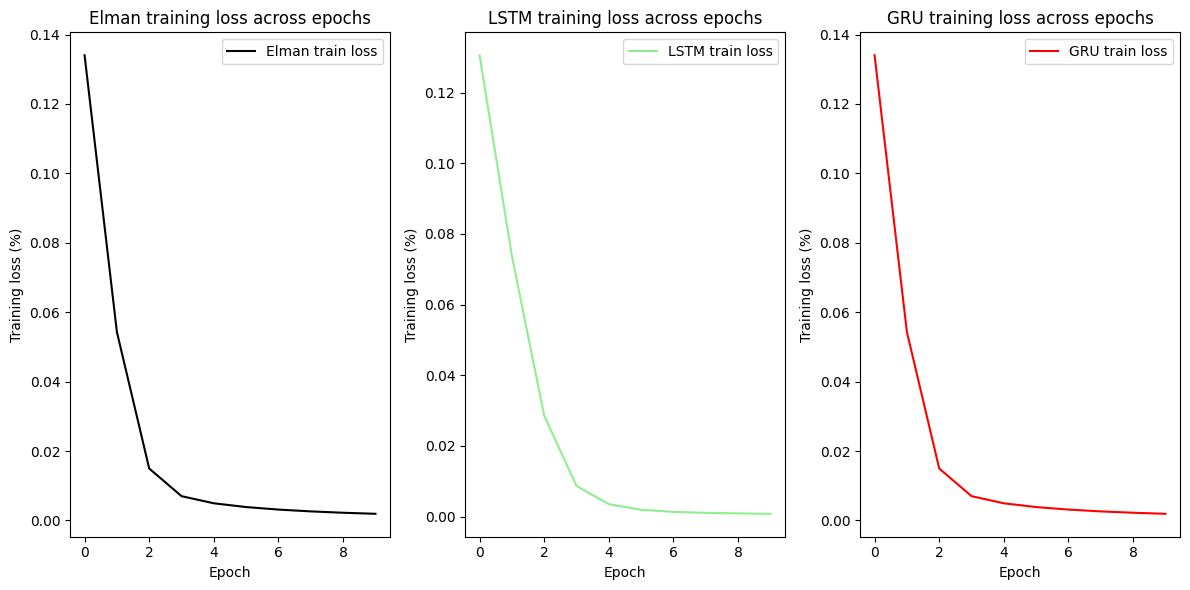

In [11]:
# plotting learning curves which is training loss across epoachs for Elman, LSTM and GRU
import matplotlib.pyplot as plt

# Plotting the learning curve
fig, axs = plt.subplots(1, 3, figsize=(12, 6)) 

# Elman 
axs[0].plot(Elman_train_losses_list, label='Elman train loss', color='black')
axs[0].set_title('Elman training loss across epochs')
axs[0].legend()
axs[0].set_ylabel('Training loss (%)')
axs[0].set_xlabel('Epoch')

# LSTM
axs[1].plot(LSTM_train_losses_list, label='LSTM train loss', color='lightgreen')
axs[1].set_title('LSTM training loss across epochs')
axs[1].legend()
axs[1].set_ylabel('Training loss (%)')
axs[1].set_xlabel('Epoch')

# GRU
axs[2].plot(GRU_train_losses_list, label='GRU train loss', color='red')
axs[2].set_title('GRU training loss across epochs')
axs[2].legend()
axs[2].set_ylabel('Training loss (%)')
axs[2].set_xlabel('Epoch')

# displaying the plot without overlap
plt.tight_layout()
plt.show()


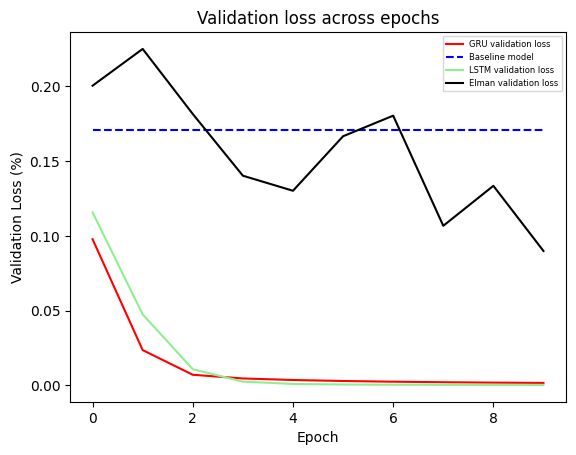

In [12]:
import matplotlib.pyplot as plt

# Plot the validation losses across epoachs with the baseline model loss
plt.plot(GRU_valid_loss_list, label='GRU validation loss', color='red')
plt.plot(baseModelLoss_list, label='Baseline model', color='blue', linestyle='--')
plt.plot(LSTM_valid_loss_list, label='LSTM validation loss', color='lightgreen')
plt.plot(Elman_valid_loss_list, label='Elman validation loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss (%)')
plt.title('Validation loss across epochs')
plt.legend(loc='upper right', fontsize='6')
plt.show()


##### OBSERVATIONS: 

* From the above plots we can observe that GRU performs better on adding problem task as it learns faster and also it performs better on validation set than elman. <BR>
* Elman training loss decreased faster, so that means network learnt faster in less epochs but its performance on validation set is not good. <BR>
* LSTM would come between Elman and GRU, slightly slower in learning but performs better than GRU on validation set.

<b>END OF PROBLEM 2<b>